# Description

In this notebook I am building a model with ExtraTreesClassifier, tuning it with GridSearchCV.

After that - I am using validation set to analyse the quality of model prediction and trying to remove some features to improve it


In [119]:
import pandas as pd
import os
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import multiprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option('display.max_columns', None)

In [8]:
screenshots = pd.read_csv("images/screenshots/screenshots.csv")

regulars = pd.read_csv("images/regular/regular.csv")

not_good = pd.read_csv("images/not_good/not_good.csv")

superb = pd.read_csv("images/superb/superb.csv")

docs = pd.read_csv("images/docs/docs.csv")

test = pd.read_csv("images/test/test.csv")

regulars["screenshots"] = 0
not_good["screenshots"] = 0
superb['screenshots'] = 0
screenshots["screenshots"] = 1
docs["screenshots"] = 0

whole_docs = pd.concat([regulars, not_good, superb, screenshots, docs], ignore_index=True)

In [9]:
whole_docs = whole_docs.drop(columns=["filename", "depth", "texture_contrast", "ch"])

In [10]:
y = whole_docs.pop("screenshots")

In [11]:
X_train, X_test, y_train, y_test = train_test_split(whole_docs, y, test_size=0.15, random_state=42)

In [13]:
full_pipeline = make_pipeline(SimpleImputer(), MinMaxScaler(),ExtraTreesClassifier())

In [15]:
param_grid = {
    'extratreesclassifier__n_estimators': range(100,400,50),
    'extratreesclassifier__min_samples_split': range(2,19,2),
    'extratreesclassifier__min_samples_leaf': range(1,13,2),
}


In [16]:
search_scr = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=10,
                      verbose=1,
                      n_jobs=multiprocessing.cpu_count()-1)

In [17]:
%%time
search_scr.fit(X_train, y_train)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
CPU times: user 5.7 s, sys: 2.41 s, total: 8.11 s
Wall time: 1min 33s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('extratreesclassifier',
                                        ExtraTreesClassifier())]),
             n_jobs=7,
             param_grid={'extratreesclassifier__min_samples_leaf': range(1, 13, 2),
                         'extratreesclassifier__min_samples_split': range(2, 19, 2),
                         'extratreesclassifier__n_estimators': range(100, 400, 50)},
             verbose=1)

In [18]:
search_scr.best_score_

0.955072463768116

In [19]:
search_scr.best_params_

{'extratreesclassifier__min_samples_leaf': 1,
 'extratreesclassifier__min_samples_split': 2,
 'extratreesclassifier__n_estimators': 200}

In [22]:
test = test.drop(columns=["depth", "texture_contrast", "ch"])

In [23]:
filenames = test.pop("filename")

In [24]:
prediction = search_scr.predict(test)

In [29]:
result = pd.DataFrame()
result['filename'] = filenames
result['prediction'] = prediction

In [45]:
result.loc[(result.prediction == 1) & (result.filename.str.contains("screen")), "metric"] = "true"

In [46]:
result.loc[(result.prediction == 0) & (result.filename.str.contains("screen")), "metric"] = "FP"
result.loc[(result.prediction == 0) & (~result.filename.str.contains("screen")), "metric"] = "not true"
result.loc[(result.prediction == 1) & (~result.filename.str.contains("screen")), "metric"] = "FN"

In [47]:
result.groupby("metric").count()

,filename,prediction,screenshot
metric,,,
FN,1,1,1
FP,3,3,3
not true,58,58,58
true,28,28,28


In [74]:
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import get_scorer_names

In [102]:
cv = KFold(n_splits=10, shuffle=True, random_state=42) 

In [103]:
test_lofo = whole_docs.copy()
test_lofo["screenshot"] = y.copy()

In [104]:
dataset = Dataset(df=test_lofo, target="screenshot", features=[col for col in test_lofo.columns if col != "screenshot"])


In [105]:
%%time
lofo_imp = LOFOImportance(dataset, cv=cv, model=full_pipeline, scoring="accuracy")

CPU times: user 17 µs, sys: 36 µs, total: 53 µs
Wall time: 62.9 µs


In [106]:
%%time
importance_df = lofo_imp.get_importance()

  0%|          | 0/46 [00:00<?, ?it/s]

CPU times: user 45.7 s, sys: 321 ms, total: 46 s
Wall time: 46.3 s


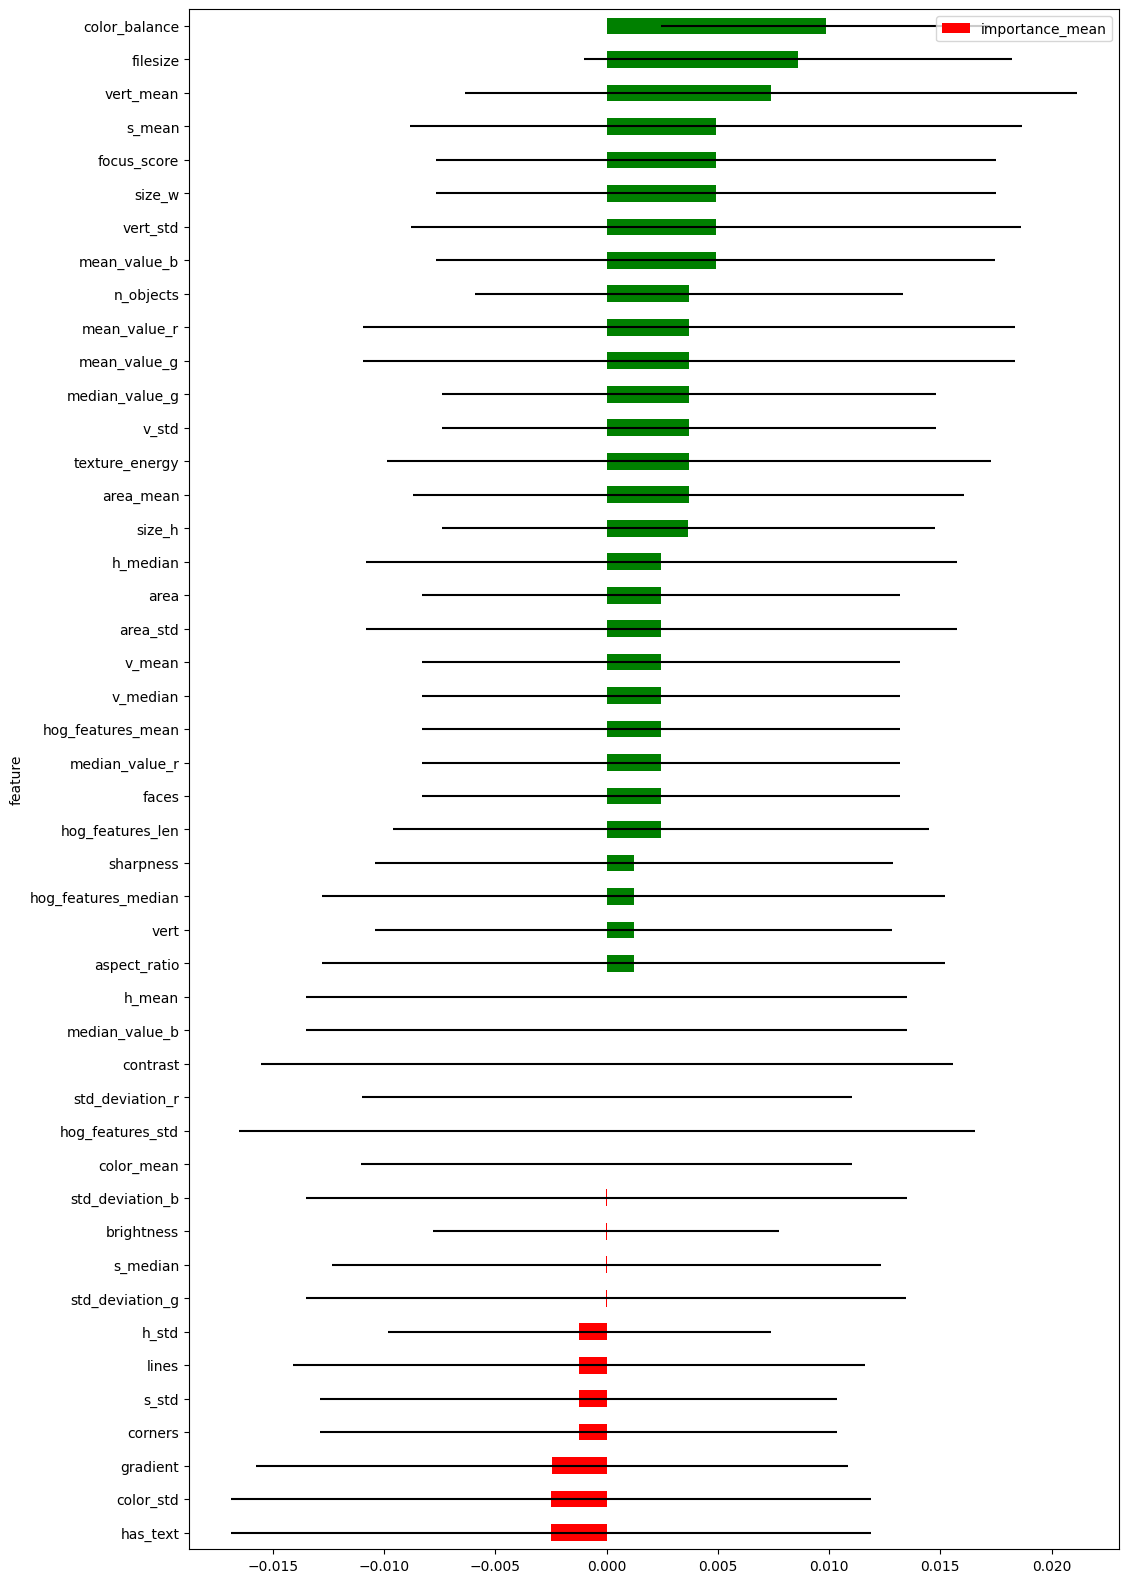

In [107]:
plot_importance(importance_df, figsize=(12, 20))

In [114]:
features_to_drop = importance_df.sort_values("importance_mean").head(11)["feature"]

In [115]:
whole_doc_less_features = whole_docs.drop(columns=features_to_drop)

In [116]:
%%time
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(whole_doc_less_features, y, test_size=0.15, random_state=42)

full_pipeline_l = make_pipeline(SimpleImputer(), MinMaxScaler(),ExtraTreesClassifier())

param_grid_l = {
    'extratreesclassifier__n_estimators': range(50,500,50),
    'extratreesclassifier__min_samples_split': range(2,19,2),
    'extratreesclassifier__min_samples_leaf': range(1,13,2),
}


search_scr_l = GridSearchCV(full_pipeline_l,
                      param_grid_l,
                      cv=10,
                      verbose=1,
                      n_jobs=multiprocessing.cpu_count()-1)


search_scr_l.fit(X_train_l, y_train_l)

search_scr_l.best_score_

Fitting 10 folds for each of 486 candidates, totalling 4860 fits
CPU times: user 14.1 s, sys: 3.83 s, total: 17.9 s
Wall time: 8min 4s


0.9507246376811596

In [117]:
search_scr.best_params_

{'extratreesclassifier__min_samples_leaf': 1,
 'extratreesclassifier__min_samples_split': 2,
 'extratreesclassifier__n_estimators': 200}

In [118]:
test_l = test.drop(columns=features_to_drop)


prediction_l = search_scr_l.predict(test_l)

result_l = pd.DataFrame()
result_l['filename'] = filenames
result_l['prediction'] = prediction

result_l.loc[(result_l.prediction == 1) & (result_l.filename.str.contains("screen")), "metric"] = "true"
result_l.loc[(result_l.prediction == 0) & (result_l.filename.str.contains("screen")), "metric"] = "FP"
result_l.loc[(result_l.prediction == 0) & (~result_l.filename.str.contains("screen")), "metric"] = "not true"
result_l.loc[(result_l.prediction == 1) & (~result_l.filename.str.contains("screen")), "metric"] = "FN"

result_l.groupby("metric").count()

,filename,prediction
metric,,
FN,1,1
FP,3,3
not true,58,58
true,28,28
